# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

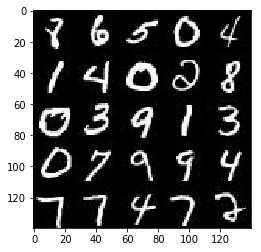

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

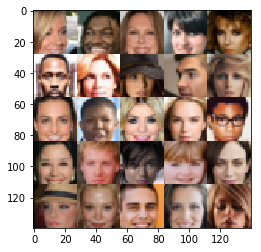

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/prominent/anaconda3/envs/face-generation/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='z_dim')
    learning_rate=tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images,reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        layer1=tf.layers.conv2d(images,128,3,strides=2,padding='same')
        layer1=tf.maximum(alpha*layer1,layer1)
        
        layer2=tf.layers.conv2d(layer1,256,3,strides=2,padding='same')
        layer2=tf.layers.batch_normalization(layer2,training=True)
        layer2=tf.maximum(layer2*alpha,layer2)
        
        layer3=tf.layers.conv2d(layer2,512,3,strides=2,padding='same')
        layer3=tf.layers.batch_normalization(layer3,training=True)
        layer3=tf.maximum(alpha*layer3,layer3)
        
        flatten=tf.reshape(layer3,(-1,4*4*512))
        logits=tf.layers.dense(flatten,1)
        out=tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim,is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=(not is_train)):
        layer1=tf.layers.dense(z,4*4*512)
        layer1=tf.reshape(layer1,(-1,4,4,512))
        layer1=tf.layers.batch_normalization(layer1,training=is_train)
        layer1=tf.maximum(alpha*layer1,layer1)
        
        layer2=tf.layers.conv2d_transpose(layer1,256,4,strides=1,padding='valid')
        layer2=tf.layers.batch_normalization(layer2,training=is_train)
        layer2=tf.maximum(alpha*layer2,layer2)
        
        layer3=tf.layers.conv2d_transpose(layer2,128,3,strides=2,padding='same')
        layer3=tf.layers.batch_normalization(layer3,training=is_train)
        layer3=tf.maximum(alpha*layer3,layer3)
        
        logits=tf.layers.conv2d_transpose(layer3,out_channel_dim,3,strides=2,padding='same')
        out=tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1-smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width,image_height,image_channels=data_shape[1],data_shape[2],data_shape[3]
    inputs_real,inputs_z,lr=model_inputs(image_width,image_height,image_channels, z_dim)  
    d_loss,g_loss=model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt,g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples,losses = [],[]
    steps=0
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model  
                steps+=1
                batch_images = batch_images*2
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ = sess.run(d_train_opt,feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt,feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                #_ = sess.run(g_train_opt,feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, inputs_z, data_shape[-1], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    return losses,samples

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 8.1899
Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 9.2147
Epoch 1/2... Discriminator Loss: 0.6189... Generator Loss: 2.0389
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 4.1787
Epoch 1/2... Discriminator Loss: 4.2245... Generator Loss: 12.6655
Epoch 1/2... Discriminator Loss: 0.4853... Generator Loss: 2.7801
Epoch 1/2... Discriminator Loss: 0.4949... Generator Loss: 2.6515
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 2.2300
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 3.0806
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.6676


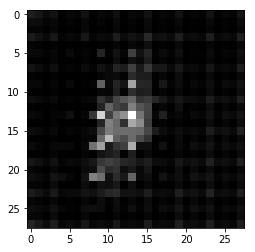

Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 2.6585
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.8278
Epoch 1/2... Discriminator Loss: 1.8482... Generator Loss: 4.4210
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 1.7567
Epoch 1/2... Discriminator Loss: 2.9281... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 1.6891
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 1.3113
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 1.5995
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 0.6606


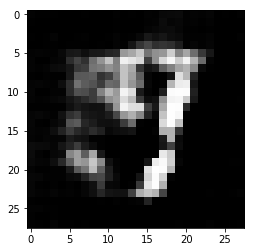

Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 1.3004
Epoch 1/2... Discriminator Loss: 2.1677... Generator Loss: 3.4450
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 2.1320
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 2.7660
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 1.4953
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 1.3130
Epoch 1/2... Discriminator Loss: 1.6812... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7549
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.6095


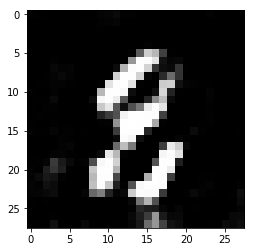

Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.5999
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 1.0811
Epoch 1/2... Discriminator Loss: 1.6297... Generator Loss: 0.4915
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 2.1728
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 1.5269
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 1.6048


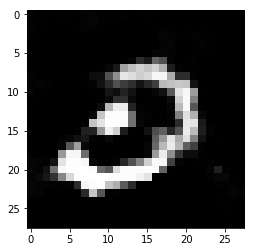

Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 1.1231
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.9136
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 1.8569
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.0496
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 1.6000
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.8294


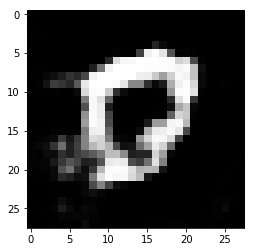

Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 2.0854... Generator Loss: 0.4438
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 1.1697
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 1.3205
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.2516


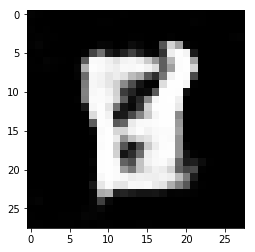

Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.7550... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.5357
Epoch 1/2... Discriminator Loss: 1.7114... Generator Loss: 1.9136
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 1.7286
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 2.2730
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.6073


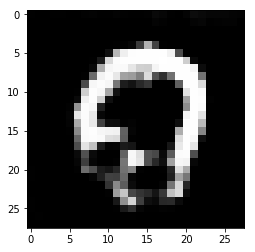

Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 1.6132
Epoch 1/2... Discriminator Loss: 2.7166... Generator Loss: 3.2397
Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 1.6817
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 1.0275
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 1.2631
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.5944


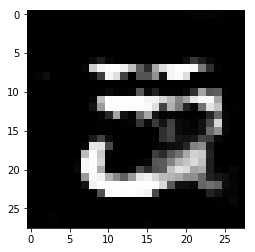

Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 2.4731
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.5196
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 0.9418


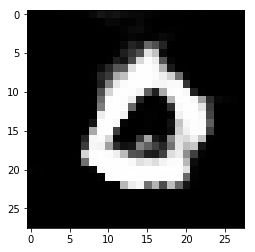

Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.5385
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 1.2071
Epoch 1/2... Discriminator Loss: 2.4572... Generator Loss: 2.6108
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 1.6943
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.6546


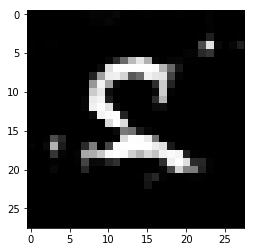

Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 1.2957
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 2.1635
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.5749
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.5501


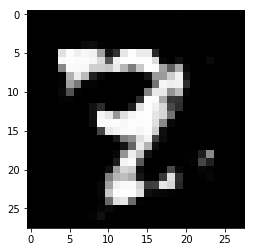

Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.3057
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 1.6717
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 2.6540
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 1.7225
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 2.2950
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 0.7640


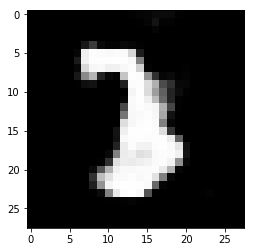

Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 1.8499
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.1232
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 1.3935
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 1.5925
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 1.6963
Epoch 1/2... Discriminator Loss: 1.4647... Generator Loss: 2.0859
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 1.3669


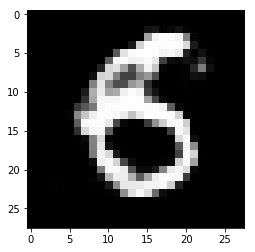

Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 2.0067... Generator Loss: 0.4098
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 1.3188
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 2.3233
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 1.3532
Epoch 1/2... Discriminator Loss: 2.1532... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.2522
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 1.2188


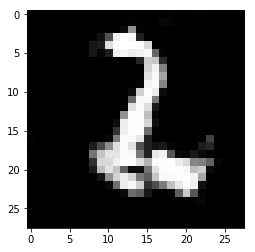

Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 1.9052
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 1.3911
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 0.6368... Generator Loss: 1.8956
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.6293... Generator Loss: 0.4815
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 1.3293


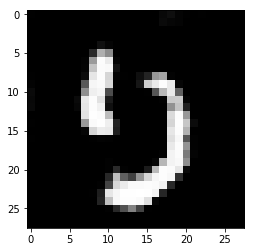

Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 1.7603
Epoch 1/2... Discriminator Loss: 0.5727... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 1.5736
Epoch 1/2... Discriminator Loss: 0.6512... Generator Loss: 1.5182
Epoch 1/2... Discriminator Loss: 0.4746... Generator Loss: 2.2832
Epoch 1/2... Discriminator Loss: 1.6868... Generator Loss: 0.5253
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 1.6403
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 0.9481


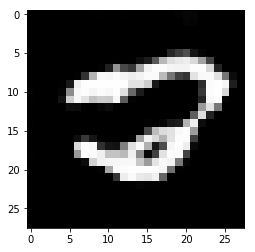

Epoch 1/2... Discriminator Loss: 0.5153... Generator Loss: 2.0670
Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 0.7366... Generator Loss: 1.2494
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 1.7579


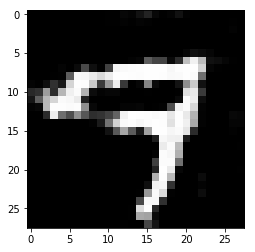

Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 0.7551... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 1.6408
Epoch 1/2... Discriminator Loss: 2.0058... Generator Loss: 3.2213
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.4868
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.4405


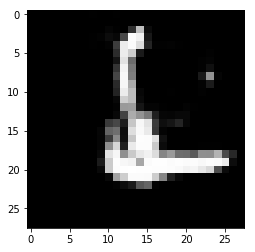

Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 1.8457
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 3.2671
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.3306
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 2.2372
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 0.4973
Epoch 2/2... Discriminator Loss: 1.5403... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 3.4987
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.7107


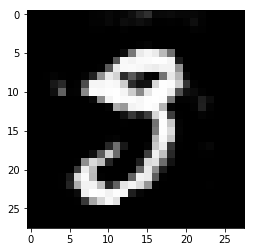

Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 2.5926
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.0258
Epoch 2/2... Discriminator Loss: 0.9447... Generator Loss: 0.9525
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 2.9674
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.5117
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.8302
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 2.2663
Epoch 2/2... Discriminator Loss: 0.6469... Generator Loss: 1.6235
Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 1.1372


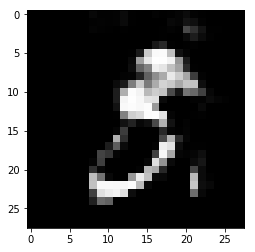

Epoch 2/2... Discriminator Loss: 1.5244... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.5432
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 2.1627
Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 2.2826
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 1.5551
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.0723


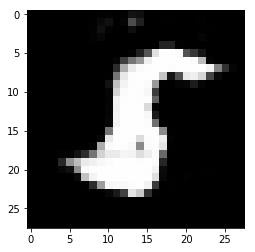

Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.1265
Epoch 2/2... Discriminator Loss: 2.2650... Generator Loss: 0.4503
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 2.3337
Epoch 2/2... Discriminator Loss: 0.6082... Generator Loss: 2.5834
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.2800
Epoch 2/2... Discriminator Loss: 0.6031... Generator Loss: 1.6218
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.3338
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.5592
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.1173


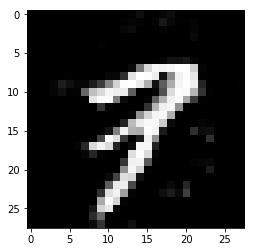

Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.5875
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 3.0300
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 1.7236
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.3399
Epoch 2/2... Discriminator Loss: 1.5220... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.1037
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.1826


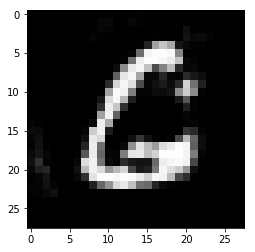

Epoch 2/2... Discriminator Loss: 2.2628... Generator Loss: 0.3858
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 2.8841
Epoch 2/2... Discriminator Loss: 0.5507... Generator Loss: 1.9861
Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.1571


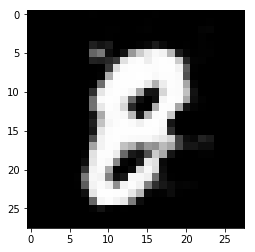

Epoch 2/2... Discriminator Loss: 0.6932... Generator Loss: 1.3642
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 1.8566
Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 1.7789
Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 1.6057
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.3898
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 1.1652
Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 2.1183
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.7592


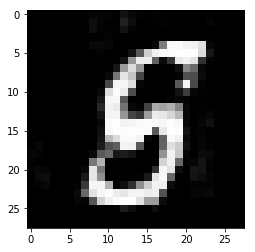

Epoch 2/2... Discriminator Loss: 1.5678... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.6660
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.7329
Epoch 2/2... Discriminator Loss: 1.5042... Generator Loss: 3.9000
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.2628
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 2.7444
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 2.5237
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 2.0210


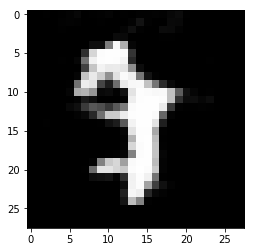

Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 2.1757
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.3774
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.6295
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 0.5411... Generator Loss: 2.7866
Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 0.5913
Epoch 2/2... Discriminator Loss: 1.5913... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.4307
Epoch 2/2... Discriminator Loss: 0.5549... Generator Loss: 1.7223


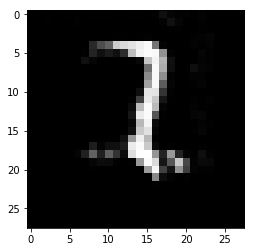

Epoch 2/2... Discriminator Loss: 1.7202... Generator Loss: 0.5355
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.1761
Epoch 2/2... Discriminator Loss: 1.8840... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.7497
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.1125
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.3794
Epoch 2/2... Discriminator Loss: 0.5237... Generator Loss: 2.1963
Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.2935
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.7956


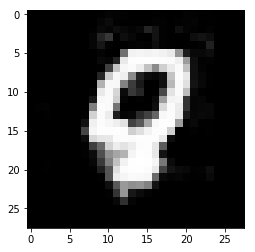

Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 2.2503
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 2.0843
Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 1.6739... Generator Loss: 0.5194
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.1719
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.9172
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.9115


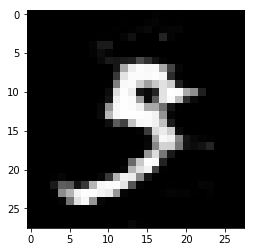

Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.4641
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 0.5133... Generator Loss: 1.9743
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.3265
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.6495
Epoch 2/2... Discriminator Loss: 0.5622... Generator Loss: 1.8436
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.7480... Generator Loss: 0.5131


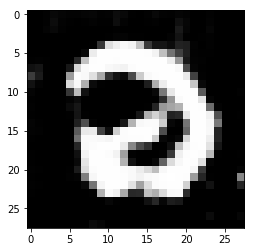

Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 1.6693
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 2.3826
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.3873
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.4536
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.2463


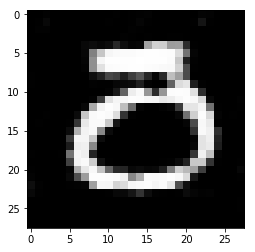

Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 2.0931
Epoch 2/2... Discriminator Loss: 0.7226... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 2.8105... Generator Loss: 0.3785
Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.7040
Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.9695
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.1881
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 2.6932
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 2.0555
Epoch 2/2... Discriminator Loss: 0.5917... Generator Loss: 2.1584


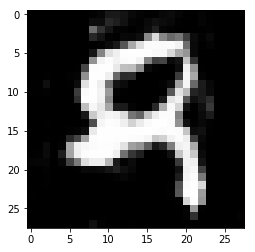

Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.5059
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.6961
Epoch 2/2... Discriminator Loss: 0.4923... Generator Loss: 1.9604
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 0.9652... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 0.5648... Generator Loss: 1.7904
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 2.2331
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 0.9577


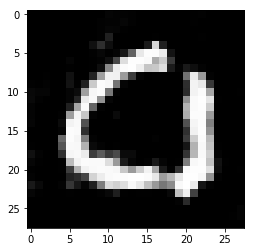

Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 0.5521... Generator Loss: 1.8231
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 2.2577
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.8202
Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.4418
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 2.1781... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.7370... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.6530


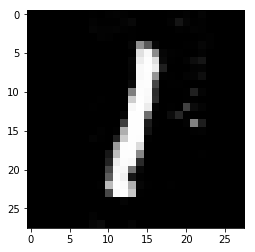

Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.5848
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.8514
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.1882
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 1.7962
Epoch 2/2... Discriminator Loss: 1.9251... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 2.5760


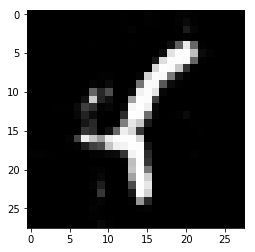

Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.4326
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 1.6232
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.5172
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.9312
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 1.4164
Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.1497


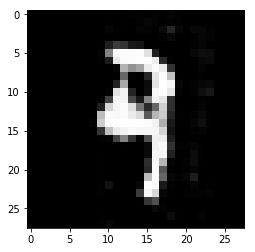

Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 1.8666
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 2.5413
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.3831
Epoch 2/2... Discriminator Loss: 2.5536... Generator Loss: 0.3955
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.2922
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.2282
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 2.1101... Generator Loss: 4.1912
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 2.6997


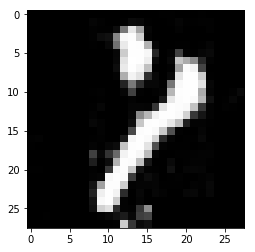

Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.3242
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.3545
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 2.7589
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.7868


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.6362
Epoch 1/1... Discriminator Loss: 3.6688... Generator Loss: 25.4283
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 9.8360
Epoch 1/1... Discriminator Loss: 2.1503... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 3.3404
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 2.0758
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 3.8177
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 3.4996
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 2.3664


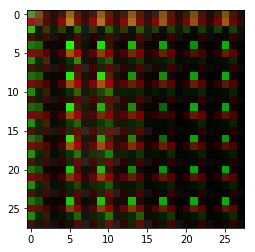

Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.8749
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 3.8537... Generator Loss: 0.3668
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.6794
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 3.8006
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.8047... Generator Loss: 2.4266
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 1.8268... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.5352


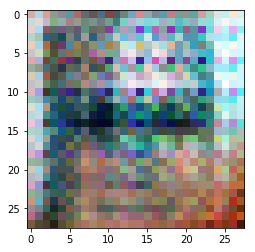

Epoch 1/1... Discriminator Loss: 5.9065... Generator Loss: 8.2824
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 2.6862
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.8170
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 1.9197... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 3.6195... Generator Loss: 5.3899
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 1.0127


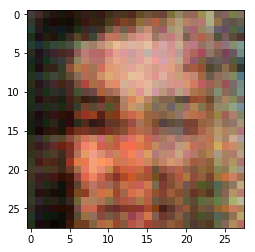

Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 4.0450
Epoch 1/1... Discriminator Loss: 3.2960... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.6929
Epoch 1/1... Discriminator Loss: 1.8909... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 2.5096
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.2662


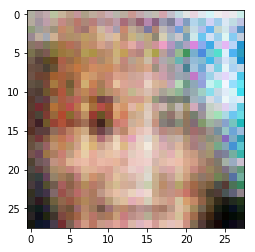

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 3.6500
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 3.5285
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 3.1760
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.4760


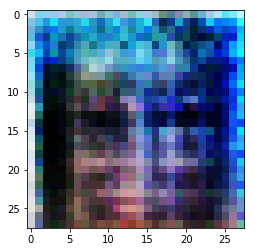

Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 3.7444
Epoch 1/1... Discriminator Loss: 2.4225... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 2.0920... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.9683


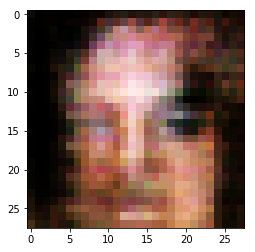

Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.8995
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.2952
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 2.0854
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 2.9520


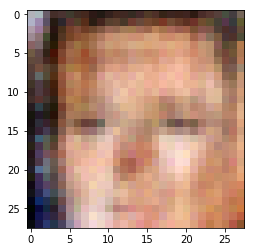

Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.8170... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.9097
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 2.7368


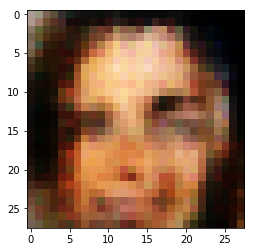

Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 2.3691
Epoch 1/1... Discriminator Loss: 2.3023... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 2.4857
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 2.5881
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.3599
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.0589


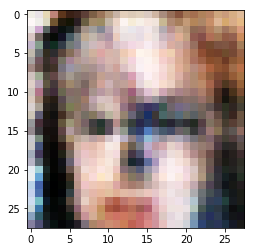

Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 3.5883
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 1.8565... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 1.8215
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 1.9353... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 2.8806... Generator Loss: 4.5347
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9534


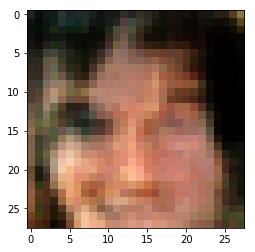

Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.5484
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 2.3757
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 3.5160
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 3.5239


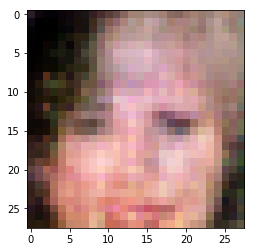

Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.8364... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 3.0051... Generator Loss: 4.4621
Epoch 1/1... Discriminator Loss: 1.7804... Generator Loss: 5.0433
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.5104
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.8768
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.8658


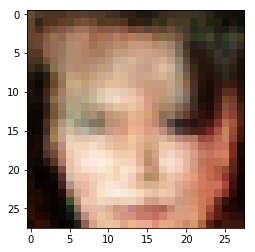

Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.6255
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.1547
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.2352
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 3.6032
Epoch 1/1... Discriminator Loss: 3.3323... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 2.2541
Epoch 1/1... Discriminator Loss: 1.9937... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.9900


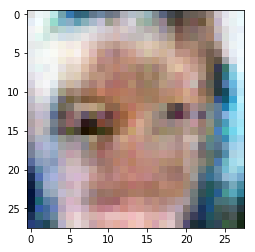

Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.1746
Epoch 1/1... Discriminator Loss: 1.7728... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 2.5184
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.9174


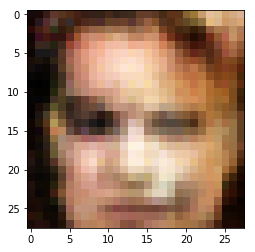

Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.8577
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 2.5749
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.5971
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.5871
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 4.4761
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9900


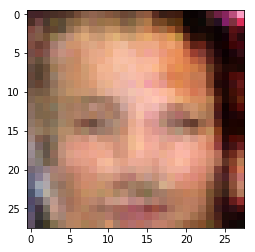

Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.3137
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.3431
Epoch 1/1... Discriminator Loss: 2.6101... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.8783... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 2.4027
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.9537
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 2.9814
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 3.0001
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.6970


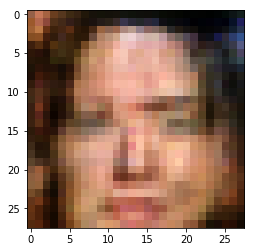

Epoch 1/1... Discriminator Loss: 1.9199... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 3.0171
Epoch 1/1... Discriminator Loss: 3.1850... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 2.2255
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 2.0097... Generator Loss: 2.9062
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.6778


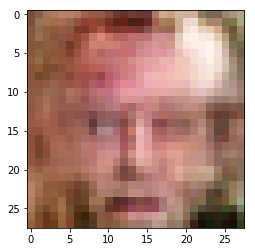

Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 2.5746
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.2037
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 2.6669
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 2.9563
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 2.0505... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 3.5135
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 0.9637


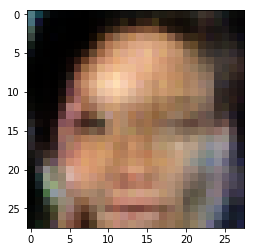

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 2.2245
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.3656
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 2.3096
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.9192
Epoch 1/1... Discriminator Loss: 2.1137... Generator Loss: 4.2517
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 3.4047
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.2993
Epoch 1/1... Discriminator Loss: 2.9650... Generator Loss: 0.3564


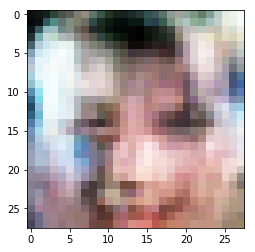

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 3.1377
Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 2.6751
Epoch 1/1... Discriminator Loss: 1.9586... Generator Loss: 3.8191
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 2.7469
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.3969


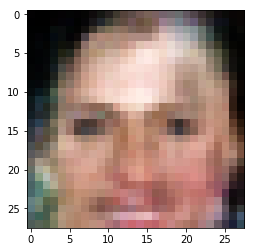

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.7565... Generator Loss: 2.7554
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 2.5872
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.5055


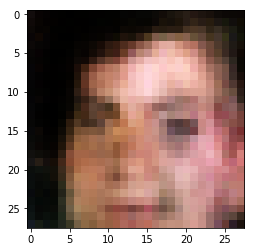

Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.9066


KeyboardInterrupt: 

In [16]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。